# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом _«Не бит, не крашен»_ разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Необходимо **построить модель**, которая умеет её определять. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

_Примечания_: Для оценки качества моделей необходимо применять метрику **RMSE** (корень среднеквадратичного отклонения). Значение метрики RMSE должно быть меньше ± **2500**€.
___

## Подготовка данных

In [1]:
# импорт основных библиотек
import os
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# импорт спец. библиотек
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

# адреса расположения файла
home_path = 'datasets/autos.csv'
server_path = '/datasets/autos.csv'

### Чтение и знакомство с данными

In [2]:
# домашняя версия
if os.path.exists(home_path):
    df = pd.read_csv(home_path, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])    

# сетевая версия
elif os.path.exists(server_path):
    df = pd.read_csv(server_path, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

else:
    print('Не удалось прочесть файл. Возможно, был указан неверный путь.')

In [3]:
# изменение порядка столбцов
df = df.reindex(columns=['Brand', 'Model', 'VehicleType', 'Gearbox', 'Power',  'FuelType', 'Kilometer',
                         'RegistrationYear', 'RegistrationMonth', 'Repaired', 'NumberOfPictures', 'Price',
                         'DateCreated', 'DateCrawled', 'LastSeen', 'PostalCode'])
display(df.head())

,Brand,Model,VehicleType,Gearbox,Power,FuelType,Kilometer,RegistrationYear,RegistrationMonth,Repaired,NumberOfPictures,Price,DateCreated,DateCrawled,LastSeen,PostalCode
0,volkswagen,golf,NaN,manual,0,petrol,150000,1993,0,NaN,0,480,2016-03-24,2016-03-24 11:52:17,2016-04-07 03:16:57,70435
1,audi,NaN,coupe,manual,190,gasoline,125000,2011,5,yes,0,18300,2016-03-24,2016-03-24 10:58:45,2016-04-07 01:46:50,66954
2,jeep,grand,suv,auto,163,gasoline,125000,2004,8,NaN,0,9800,2016-03-14,2016-03-14 12:52:21,2016-04-05 12:47:46,90480
3,volkswagen,golf,small,manual,75,petrol,150000,2001,6,no,0,1500,2016-03-17,2016-03-17 16:54:04,2016-03-17 17:40:17,91074
4,skoda,fabia,small,manual,69,gasoline,90000,2008,7,no,0,3600,2016-03-31,2016-03-31 17:25:20,2016-04-06 10:17:21,60437


**Описание данны**:
- `Brand` — марка автомобиля
- `Model` — модель автомобиля
- `VehicleType` — тип автомобильного кузова
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `FuelType` — тип топлива
- `Kilometer` — пробег (км)
- `RegistrationYear` — год первой регистрации автомобиля*
- `RegistrationMonth` — месяц первой регистрации автомобиля*
- `Repaired` — была машина в ремонте или нет
- `NumberOfPictures` — количество фотографий автомобиля
- `Price` — цена в евро, € (_целевой признак_)

- `DateCreated` — дата публикации объявления**
- `DateCrawled` — дата скачивания анкеты объявления из базы**
- `LastSeen` — дата последней активности пользователя
- `PostalCode` — почтовый индекс пользователя, разместившего объявления


\* первая регистрация автомобиля, сразу после его производства.

\** дата в формате: ГГГГ-ММ-ДД чч:мм:сс

\*** термин _анкета_, который использовался в формулировке задания, был замнён на слово _объявление_ для бóльшего понимания.


In [4]:
df.info() # техническая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Brand              354369 non-null  object        
 1   Model              334664 non-null  object        
 2   VehicleType        316879 non-null  object        
 3   Gearbox            334536 non-null  object        
 4   Power              354369 non-null  int64         
 5   FuelType           321474 non-null  object        
 6   Kilometer          354369 non-null  int64         
 7   RegistrationYear   354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   Repaired           283215 non-null  object        
 10  NumberOfPictures   354369 non-null  int64         
 11  Price              354369 non-null  int64         
 12  DateCreated        354369 non-null  datetime64[ns]
 13  DateCrawled        354369 non-null  datetime

In [5]:
# функция поиска пропусков
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind='barh', figsize=(14, 6), grid=True, legend=False, title='Доля пропусков в датафрейма (значения в %)')
        );
    except:
        print('Пропуски - отсутствуют.')

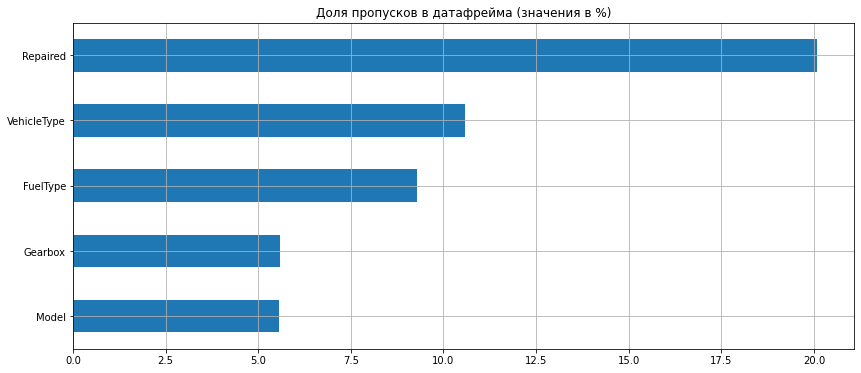

In [6]:
pass_value_barh(df)

Датасет (набор данных) содержит более 354 000 строк и 16 столбцов. Каждая строчка это автомобиль, который выставлялся на продажу, где столбцы это параметры характеризующие этот автомобиль. Для каждого параметра установлен соответствующий тип данных.

В датасете присутствуют дефекты:
- пропуски в колонках: `VehicleType`, `Gearbox`, `Model`, `Fuel_type`, `Repaired`;
- ошибки, к примеру: не указано стоимость автомобиля `Price = 0`;
- возможно, присутствуют дубликаты.
___

## Предобработка данных

### Стандартизация наименования колонок

Текущее наименования колонок выглядят так: `Repaired`, `NumberOfPictures`. Такой облик называется "_ВерблюжийРегистр_".

Но данные, содержащииеся в этих колонках, записаны в другом стиле: `renault`, `mercedes_benz`, а именно в "змеином_регистре", который является более распространённым и предпочтительным в сфере IT. По этой причине необходимо привести все названия к единому стандарту:

In [7]:
# функция преобразования верблюжего регистра в змеиный
def camel_to_snake(column):
    for char in column:
        if char.isupper():
            column = column.replace(char, '_' + char.lower())
    return column[1:]

In [8]:
# переименовывание колонок
for col in df.columns:
    new_col = camel_to_snake(col)
    df.rename(columns = {col : new_col}, inplace=True)

# контроль
print('Новое оглавление колонок:\n', df.columns)

Новое оглавление колонок:
 Index(['brand', 'model', 'vehicle_type', 'gearbox', 'power', 'fuel_type',
       'kilometer', 'registration_year', 'registration_month', 'repaired',
       'number_of_pictures', 'price', 'date_created', 'date_crawled',
       'last_seen', 'postal_code'],
      dtype='object')


###  Времянны́е периоды

In [9]:
print('Период скачивания объявлений:   ',
      df['date_crawled'].dt.date.min(), '-', df['date_crawled'].dt.date.max())

print('Период публикаций объявлений:   ',
      df['date_created'].dt.date.min(), '-', df['date_created'].dt.date.max())

print('Период активности пользователей:',
      df['last_seen'].dt.date.min(), '-', df['last_seen'].dt.date.max())

df['year_created'] = df['date_created'].dt.year
display(df.groupby('year_created')['brand'].count().to_frame().rename(columns = {'brand':'count'}))

Период скачивания объявлений:    2016-03-05 - 2016-04-07
Период публикаций объявлений:    2014-03-10 - 2016-04-07
Период активности пользователей: 2016-03-05 - 2016-04-07


,count
year_created,
2014,1
2015,25
2016,354343


Скачивание объявлений просходило в течении 32 дней с марта по апрель в 2016 году.
Судя по совпадению периодов скачивания объявления `date_crawled` и активности пользователей `last_seen`: в набор данных попали только активне пользователи, объявления которых **актуальны**, что заставляет их заходить на сайт и взаимодействовать с другими людьми.

Подавляющее большинство объявлений приходится на **первые месяцы 2016 год**, и лишь штучные объявления до сих пор актуальных с прошлого и позапрошлого года. Для дальнейшей работы будут отобраны только актуальные объявления, для оценки которых необходимо взглянуть то как рапределились объявления в течении времени:

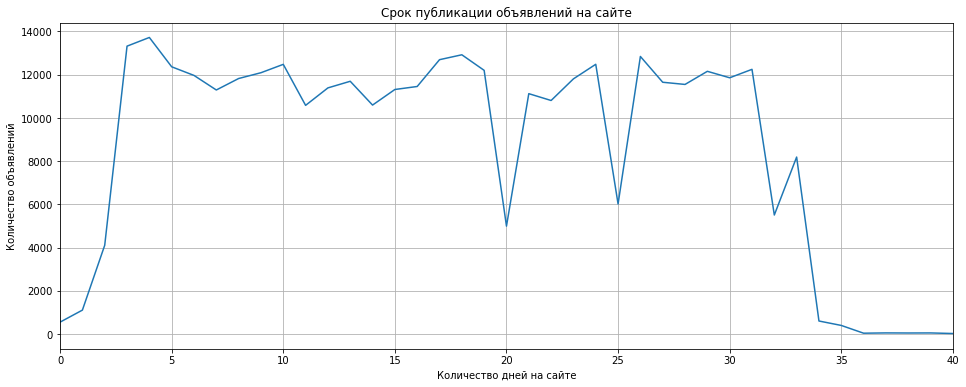

In [10]:
df['days'] = (df['date_created'].max() - df['date_created']).dt.components.days
days_distribution = df['days'].value_counts().to_frame().reset_index().sort_values(by='index')
days_distribution.plot(x='index', y='days', grid=True, figsize=(16, 6), legend=False, xlim=(0, 40),
                            title='Срок публикации объявлений на сайте',
                            ylabel='Количество объявлений',
                            xlabel='Количество дней на сайте');

Из графика видно, что основная часть объявлений актуальны **не более 35 дней**, все что свыше - автомобиль уже продан. Конечно, есть исключительные авто с большим сроком продажи, но эти случаи не носят массовый характер, и будут исключены из даньшейней работы.

In [11]:
# удаление нетипичных объектов
print(f'Из датасета удалено {len(df.query("days > 35"))} авто.')
df.query('days <= 35', inplace=True)

Из датасета удалено 580 авто.


### Дубликаты

Поскольку достоверно не известны критерии отбора объявлений при скачивания, нет возможности проконтролировать качество этого процесса. По этой причне будет выполнена проверна наличия повторно скаченных объявлений. В случае их обнаружения дубликаты будут удалены.

In [12]:
# поиск дубликатов
dupl_autos = df[df[['brand', 'model', 'vehicle_type', 'gearbox', 'power', 'fuel_type', 'kilometer',
                    'registration_year', 'registration_month', 'repaired', 'price', 'date_created']].duplicated()].index

display(df.loc[dupl_autos])
df.drop(dupl_autos, inplace=True)
print(f'\n Из датасета удалено {len(dupl_autos)} авто.')

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
4222,audi,a6,wagon,manual,140,gasoline,100000,2007,3,no,0,14500,2016-03-19,2016-03-19 21:54:30,2016-04-05 11:49:20,94060,2016,19
6360,volkswagen,golf,sedan,manual,140,gasoline,150000,2009,2,no,0,7199,2016-03-23,2016-03-23 15:47:35,2016-04-05 18:44:54,30657,2016,15
6503,ford,focus,sedan,manual,115,gasoline,150000,2004,6,NaN,0,1700,2016-03-10,2016-03-10 12:37:21,2016-03-24 13:44:37,78073,2016,28
8803,ford,mondeo,sedan,manual,0,gasoline,150000,2004,9,NaN,0,1700,2016-03-12,2016-03-12 19:52:18,2016-03-12 19:52:18,53520,2016,26
9025,volkswagen,polo,small,manual,50,petrol,150000,2000,10,no,0,1600,2016-03-24,2016-03-24 01:37:02,2016-04-06 01:46:51,38179,2016,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354311,volkswagen,golf,sedan,manual,105,gasoline,150000,2006,6,no,0,3000,2016-03-08,2016-03-08 20:43:20,2016-03-08 20:43:20,1217,2016,30
354317,seat,ibiza,small,manual,86,petrol,90000,2009,6,no,0,5990,2016-03-19,2016-03-19 19:44:29,2016-03-24 15:17:52,51371,2016,19
354352,mercedes_benz,e_klasse,sedan,auto,145,gasoline,150000,2003,3,no,0,6500,2016-03-05,2016-03-06 21:11:23,2016-03-12 12:18:05,60437,2016,33
354355,seat,leon,sedan,manual,105,gasoline,150000,2008,7,no,0,4400,2016-03-21,2016-03-21 15:36:22,2016-04-06 15:45:01,45896,2016,17



 Из датасета удалено 11765 авто.


### Дата регистрации авто

Под датой регистрации авто подразумевается момент _первичной регистрации_. Эта дата точнее характеризует автомобиль, чем дата его изготовления, посколько с момента производства до **момента начала эксплуотации** автомобиля может пройти некоторое количество времени, которое индивидуально для каждого авто. Её значения параллельны дате выпуска конкретной модели: имеют сходие границы, но доставерно угадать - невозможно. По этой причине, из датасета будут удалены автомобили дата регистрации которых:
- новее чем дата скачивания самого датасета (апрель 2016)
- старше 1990 (год, с которого начался сремительный рост кол-ва автомобилей на потребительском рынке)

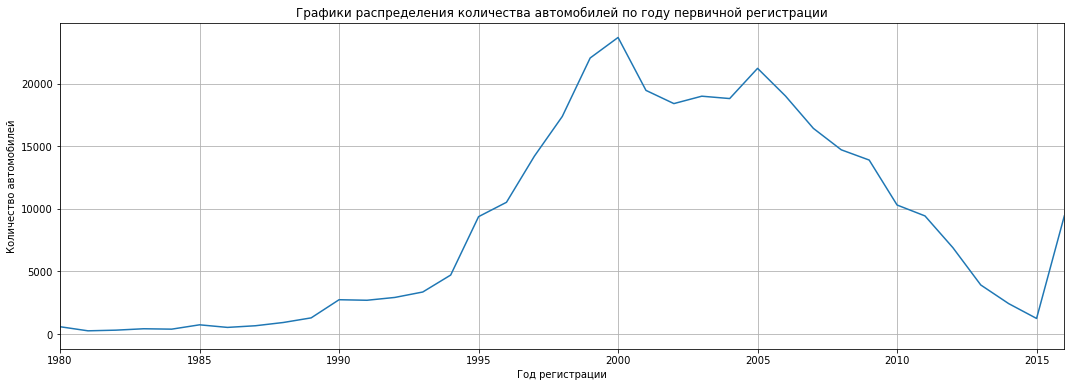

In [13]:
# распределение автомобилей по году регистрации
reg_years_distribution = df['registration_year'].value_counts().to_frame().reset_index().sort_values(by='index')
reg_years_distribution.plot(x='index', y='registration_year', grid=True, figsize=(18, 6), legend=False, xlim=(1980, 2016),
                            title='Графики распределения количества автомобилей по году первичной регистрации',
                            ylabel='Количество автомобилей',
                            xlabel='Год регистрации');

In [14]:
# удаление аномалий и выбрасов по году регистрации
delete_index = df[(((df['registration_year'] >  2016) | (df['registration_year'] < 1990)) |
                  ((df['registration_year'] == 2016) & (df['registration_month'] > 4)))].index

print(f'Из датасета удалено {len(delete_index)} авто.')
df.drop(delete_index, inplace=True)

Из датасета удалено 28303 авто.


### Мощность двигателя

In [15]:
print(f"Диапазон мощностей автомобилей в исходном датасете: {df['power'].min()} - {df['power'].max()} л.с.")

Диапазон мощностей автомобилей в исходном датасете: 0 - 20000 л.с.


Поскольку диапазон значений весьма велик, но будет уменьшен в два этапа:
- **грубый этап**, но котором будут отсечены явно ошибочные значения (к примеру 2 л.с. или 20 000 л.с.). Диапазон сузится до значений самого маломощного и самого многомощный автомобилей, данных которых можно подтвердить.
- **точный этап**, на котором диапазо можности сузиться до значений большинства автомобилей. Эти значения будут расчитаны автоматически для каждого типа кузова с помощью межквартильного размаха (пологая, что значения распределены нормально).

Это необходимо чтобы снизить влияние особо больших _выбрасов_. Остальные автомобили будут считаться непопулярными или аномальными.

Самым _маломощным_ автомобилем (26 л.с.), для которого получилось найти подтверждение, оказался [Trabant 601](https://ru.wikipedia.org/wiki/Trabant) микролитражный серийный автомобиль, выпущенный тиражом около 3 млн. автомобилей, и ставший символом ГДР (Германская Демократическая Республика).

Самым _многомощным_ (408 л.с.) авто будет считаться [Porsche 911](https://ru.wikipedia.org/wiki/Porsche_993) 4ого покаления, известный спорткар, не нуждающийся в предствалении.

Из датасета удалено 32887 авто.


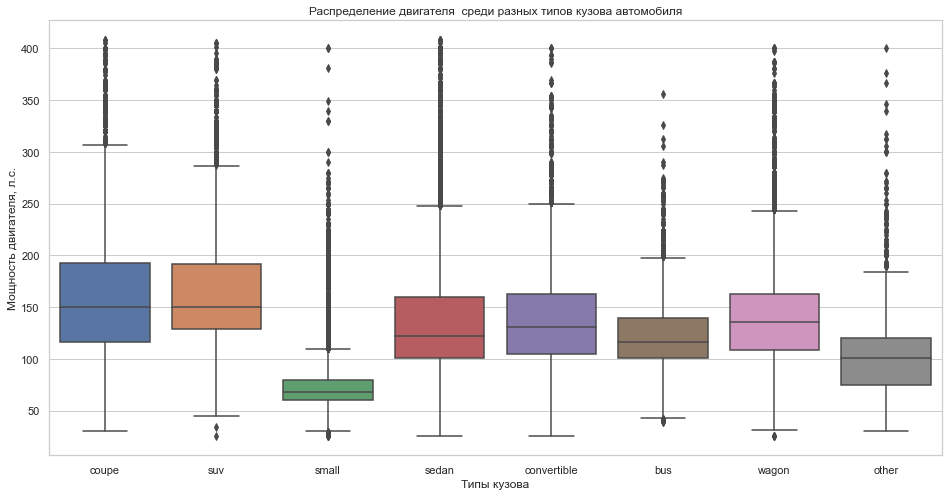

In [16]:
# грубый этап удаления аномалий
print(f'Из датасета удалено {len(df[(df["power"]<26) | (df["power"]>408)])} авто.')
df = df[(df['power'] >= 26) & (df['power'] <= 408)]

sns.set(rc = {'figure.figsize':(16, 8)})
sns.set_theme(style="whitegrid")

sns.boxplot(data=df, x='vehicle_type', y='power')
plt.title('Распределение двигателя  среди разных типов кузова автомобиля')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова');

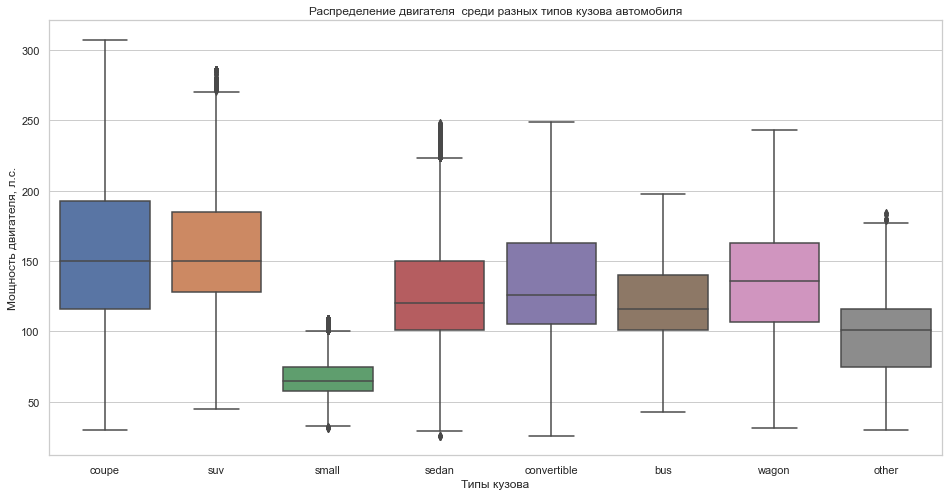

In [17]:
# точный этап удаления выбрасов
for body_type in ['sedan', 'small', 'wagon', 'bus', 'convertible', 'coupe', 'suv', 'other']:
    Q1, Q3 = df.loc[df['vehicle_type']==body_type, 'power'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    delete_index = df[(df['vehicle_type'] == body_type) &
                      ((df['power'] <= (Q1 - 1.5*IQR)) |
                       (df['power'] >= (Q3 + 1.5*IQR)))].index
    df.drop(delete_index, inplace=True)

sns.boxplot(data=df, x='vehicle_type', y='power')
plt.title('Распределение двигателя  среди разных типов кузова автомобиля')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова');

### Тип топлива

In [18]:
# подсчёт численности каждой категории авто
display(df['fuel_type']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'fuel_type':'count', 'index':'fuel_type'}))

,fuel_type,count
0,petrol,169515
1,gasoline,82205
2,NaN,14002
3,lpg,4029
4,cng,469
5,hybrid,189
6,other,48
7,electric,36


- `gasoline` и `petrol` - **бензин**. Фактически являются одним и тем топливом. А разное название пошли из двух стран: Великобритания и США, соответственно. Это может свидетельствовать о проихождении автомобиля, но косвенно. По этому все бензиновые автомобили будут объеденены под единым название `petrol`, поскольку оно вдвое распространённей.
- `lpg` - сжиженные **углеводородные газы** (обычно это смесь пропан-бутана)
- `cng` - компримированный **природный газ** (метан)
- `electric` - **электроэнергия** 
- `hybrid` - **гибридный** тип, который совмещает несколько типов топлива в одном автомобиле. Распрастранённый пример: бензиновый и электрический двигатели установленные в автомобиле Toyota Prius.
- `other` - **дргие** виды топлива, которые не попали в основные групы, либо не были явно указаны в объявлении.

In [19]:
# замена типа топлива "gasoline" на "petrol"
df.loc[df['fuel_type']=='gasoline', 'fuel_type'] = 'petrol'
print('Количество автомобилей с типом топлива "gasoline":', len(df.query('fuel_type=="gasoline"')))
print('Количество автомобилей с типом топлива "petrol"  :', len(df.query('fuel_type=="petrol"')))

Количество автомобилей с типом топлива "gasoline": 0
Количество автомобилей с типом топлива "petrol"  : 251720


In [20]:
fuel_index = []
for fuel_type in ['petrol', 'lpg', 'cng', 'electric', 'hybrid', 'other']:
    fuel_index.append(df[((df['fuel_type'] == fuel_type) &
                         ~(df['vehicle_type'].isna()) &
                         ~(df['gearbox'].isna()) &
                         ~(df['brand'].isna()) &
                         ~(df['model'].isna()) &
                         ~(df['power'].isna()))].first_valid_index())

print('\nПримеры автомобилей с каждым типом используемого топлива.')
display(df.loc[fuel_index])


Примеры автомобилей с каждым типом используемого топлива.


,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
2,jeep,grand,suv,auto,163,petrol,125000,2004,8,NaN,0,9800,2016-03-14,2016-03-14 12:52:21,2016-04-05 12:47:46,90480,2016,24
152,opel,meriva,bus,manual,101,lpg,150000,2004,10,yes,0,0,2016-03-11,2016-03-11 18:55:53,2016-03-12 23:47:10,27432,2016,27
2315,opel,zafira,bus,manual,150,cng,125000,2009,11,no,0,8600,2016-03-27,2016-03-27 14:37:04,2016-04-07 10:45:26,88048,2016,11
3244,citroen,c5,sedan,manual,99,electric,100000,1999,3,yes,0,0,2016-03-30,2016-03-30 08:57:11,2016-04-07 01:15:34,6842,2016,8
1075,toyota,other,sedan,auto,100,hybrid,150000,2007,9,no,0,5750,2016-03-26,2016-03-26 12:58:01,2016-03-29 15:16:05,32427,2016,12
363,ford,focus,sedan,manual,125,other,125000,2007,9,no,0,6500,2016-03-14,2016-03-14 23:52:32,2016-04-05 11:51:03,97199,2016,24


### Типы кузова

In [21]:
# подсчёт численности каждой категории авто
display(df['vehicle_type']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'vehicle_type':'count', 'index':'vehicle_type'}))

,vehicle_type,count
0,sedan,75599
1,small,63423
2,wagon,56559
3,bus,24793
4,convertible,16881
5,coupe,13161
6,suv,9818
7,NaN,8076
8,other,2183


- `sedan` - **седан**. Закрытый кузов легкового автомобиля с багажником, структурно отделённым от пассажирского салона.
- `small` - **хэтчбэк**. Отличается от седана укороченным задним свесом. Может содержать один или два рядя сидений.
- `wagon` - **универсал**. Представляет собой вариант седана с увеличенным багажным отделением.
- `bus` - **мини-вэн**. Однообъёмный кузов, как правило, имеющий три ряда сидений.
- `convertible` - **кабриолет** 
- `coupe` - **купе**. Зыкрытый кузов. Отличается двумя дверьми и одним (реже двумя) рядами сидений.
- `suv` - **sport utility vehicle** — «спортивно-утилитарный автомобиль») — тип автомобиля, происходящий изначально из класса внедорожников, но используемый в подавляющем большинстве случаев в городах и на асфальтированной дороге.
- `other` - **другие** автомобили не попавшие в вышепеерчисленные категории.

In [22]:
body_index = []
for body_type in ['sedan', 'small', 'wagon', 'bus', 'convertible', 'coupe', 'suv', 'other']:
    body_index.append(df[((df['vehicle_type'] == body_type) &
                         ~(df['fuel_type'].isna()) &
                         ~(df['gearbox'].isna()) &
                         ~(df['brand'].isna()) &
                         ~(df['model'].isna()) &
                         ~(df['power'].isna()))].first_valid_index())

print('\nПримеры автомобилей с каждым типом кузова.')
display(df.loc[body_index])


Примеры автомобилей с каждым типом кузова.


,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
5,bmw,3er,sedan,manual,102,petrol,150000,1995,10,yes,0,650,2016-04-04,2016-04-04 17:36:23,2016-04-06 19:17:07,33775,2016,3
3,volkswagen,golf,small,manual,75,petrol,150000,2001,6,no,0,1500,2016-03-17,2016-03-17 16:54:04,2016-03-17 17:40:17,91074,2016,21
11,volkswagen,passat,wagon,manual,140,petrol,150000,2005,12,yes,0,2799,2016-04-07,2016-04-07 10:06:22,2016-04-07 10:25:17,57290,2016,0
8,ford,c_max,bus,manual,125,petrol,30000,2014,8,NaN,0,14500,2016-04-04,2016-04-04 23:42:13,2016-04-04 23:42:13,94505,2016,3
6,peugeot,2_reihe,convertible,manual,109,petrol,150000,2004,8,no,0,2200,2016-04-01,2016-04-01 20:48:51,2016-04-05 18:18:39,67112,2016,6
20,volkswagen,scirocco,coupe,manual,160,petrol,100000,2009,4,no,0,10400,2016-04-01,2016-04-01 19:56:48,2016-04-05 16:45:49,75365,2016,6
2,jeep,grand,suv,auto,163,petrol,125000,2004,8,NaN,0,9800,2016-03-14,2016-03-14 12:52:21,2016-04-05 12:47:46,90480,2016,24
38,volkswagen,other,other,manual,129,petrol,150000,2002,11,no,0,11900,2016-04-01,2016-04-01 17:45:07,2016-04-05 12:47:30,10551,2016,6


### Типы трансмиссии

В этом параметре присутствуют пропуски. Не все владельцы (пользователи) указали тип трансмиссии. Дабы, в конечном счёте предложить пользователям бóльший выбор параметров при оценке автомобиля, будет сохранена категория "_неизвестных трасмиссий_" по названием `undefined` (не определено).

In [23]:
# подсчёт численности каждой категории авто
display(df['gearbox']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'gearbox':'count', 'index':'gearbox'}))

,gearbox,count
0,manual,214936
1,auto,50475
2,NaN,5082


### Автомобильные бренды

In [24]:
print('Перечень автомобильных брендов:\n', sorted(df['brand'].unique()))

Перечень автомобильных брендов:
 ['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']


Среди перечня уникальных значенией встречается `sonstige_autos` - это категория, которая содержит _другие_, менее популярные марки. В этой катерогии у всех отсутствует название модели, а так же не редко отстутствуют характеристиках автомобиля: _тип кузова, трансмиссия, мощность двигателя, и др._

Ввиду малой информативности, эта категория будет удалена.

In [25]:
display(df.query('brand == "sonstige_autos"'))

print(f'Из датасета удалено {len(df[df["brand"]=="sonstige_autos"])} авто.')
df.query('brand != "sonstige_autos"', inplace=True)

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
59,sonstige_autos,NaN,suv,manual,286,NaN,150000,1994,11,NaN,0,1,2016-03-29,2016-03-29 15:48:15,2016-04-06 01:44:38,53721,2016,9
661,sonstige_autos,NaN,suv,auto,250,lpg,150000,2000,4,no,0,9900,2016-04-01,2016-04-01 15:56:27,2016-04-07 14:56:03,17309,2016,6
700,sonstige_autos,NaN,sedan,auto,186,petrol,125000,2010,4,no,0,6999,2016-03-30,2016-03-30 21:37:21,2016-04-05 11:18:33,81929,2016,8
985,sonstige_autos,NaN,sedan,manual,101,petrol,70000,2010,1,yes,0,500,2016-03-15,2016-03-15 16:37:22,2016-03-21 14:15:21,76829,2016,23
1345,sonstige_autos,NaN,NaN,NaN,37,NaN,60000,1990,2,NaN,0,899,2016-03-21,2016-03-21 01:57:37,2016-03-27 21:44:30,85057,2016,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352549,sonstige_autos,NaN,wagon,manual,70,petrol,60000,2011,11,no,0,9900,2016-03-14,2016-03-14 16:54:25,2016-04-05 21:18:17,86415,2016,24
353756,sonstige_autos,NaN,small,manual,66,petrol,150000,1997,5,NaN,0,250,2016-04-01,2016-04-01 16:53:46,2016-04-05 12:17:30,7548,2016,6
353867,sonstige_autos,NaN,sedan,manual,175,petrol,125000,2006,12,no,0,5000,2016-03-28,2016-03-29 00:38:48,2016-04-05 14:16:37,71397,2016,10
353892,sonstige_autos,NaN,bus,NaN,140,petrol,125000,2009,7,no,0,7900,2016-03-06,2016-03-06 11:42:12,2016-03-26 16:16:02,97256,2016,32


Из датасета удалено 921 авто.


### Модели автомобилей

In [26]:
print('Перечень моделей:\n', sorted(df['model'].dropna().unique()))

Перечень моделей:
 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'free

При визуальном осмотре моделей, перечисленных выше, была выявлена одна ошибки в названии модели: `rangerover`. Этот штучный экземпляр имеет нетипичный тип кузова, трансмиссию и мощность двигателя для этой модели, и неверное название бренда. Всего скорей это автомобиль марки Rover, но модель установить не удастся, по этой прчине она будет удалена.

In [27]:
# удаление неявного дубликата
display(df[df['model'] == 'rangerover'])
display(df[df['model'] == 'range_rover'].head())
df.drop(df[df['model'] == 'rangerover'].index, inplace=True)

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
27949,rover,rangerover,small,manual,103,petrol,150000,1998,10,NaN,0,1050,2016-03-18,2016-03-18 01:57:30,2016-04-05 21:18:19,49084,2016,20


,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
5615,land_rover,range_rover,suv,auto,182,petrol,150000,1993,11,no,0,14900,2016-03-20,2016-03-20 11:43:28,2016-04-06 08:46:41,10781,2016,18
22356,land_rover,range_rover,suv,auto,224,NaN,150000,1996,1,no,0,2800,2016-03-22,2016-03-22 13:49:59,2016-04-06 02:45:52,59075,2016,16
32216,land_rover,range_rover,suv,auto,182,petrol,150000,1994,7,no,0,14950,2016-04-04,2016-04-05 00:39:33,2016-04-07 08:15:37,34123,2016,3
33834,land_rover,range_rover,suv,auto,224,petrol,150000,1996,2,yes,0,0,2016-03-21,2016-03-22 00:40:08,2016-03-28 22:47:52,21217,2016,17
42698,land_rover,range_rover,suv,auto,177,petrol,150000,2004,6,NaN,0,6800,2016-03-22,2016-03-22 18:46:58,2016-03-28 09:46:45,24340,2016,16


### Состояние автомобиля

О наличии (или отсутствии) крупного ремонта авмотобиля умолчало некоторая значительная часть пользователей. Они будут сохранены с аналогичной меткой: `undefined` (не определено).

In [28]:
display(df['repaired']
        .value_counts(dropna=False)
        .to_frame().reset_index()
        .rename(columns = {'repaired':'count', 'index':'repaired'}))

# заполнение пропусков
df['repaired'].fillna('undefined', inplace=True)

,repaired,count
0,no,202180
1,NaN,39874
2,yes,27517


### Пробег автомобилей

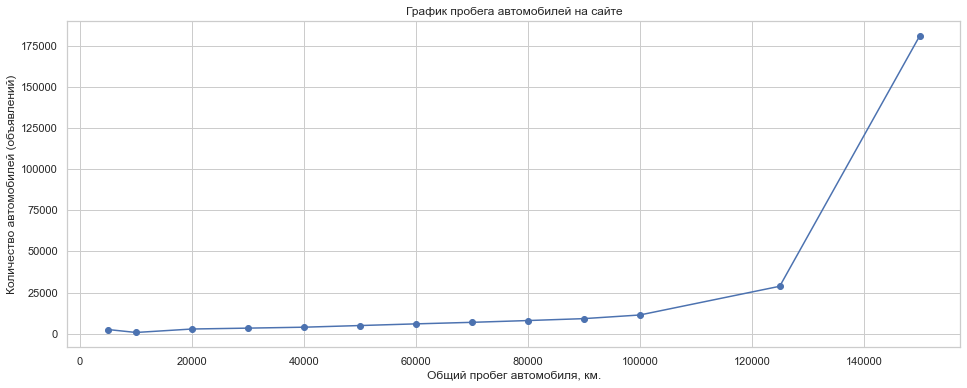

In [29]:
kilometer_distribution = df['kilometer'].value_counts().to_frame().reset_index().sort_values(by='index')
kilometer_distribution.plot(style='o-', x='index', y='kilometer', grid=True, figsize=(16, 6), legend=False,
                            title='График пробега автомобилей на сайте',
                            ylabel='Количество автомобилей (объявлений)',
                            xlabel='Общий пробег автомобиля, км.');

### Стоимость автомобиля (целевой признак)

Стоимости автомобилей начинается от 0€ и ступенчато возростает до 20 000€.
Аномально дешёвые автомобили будут удалены.

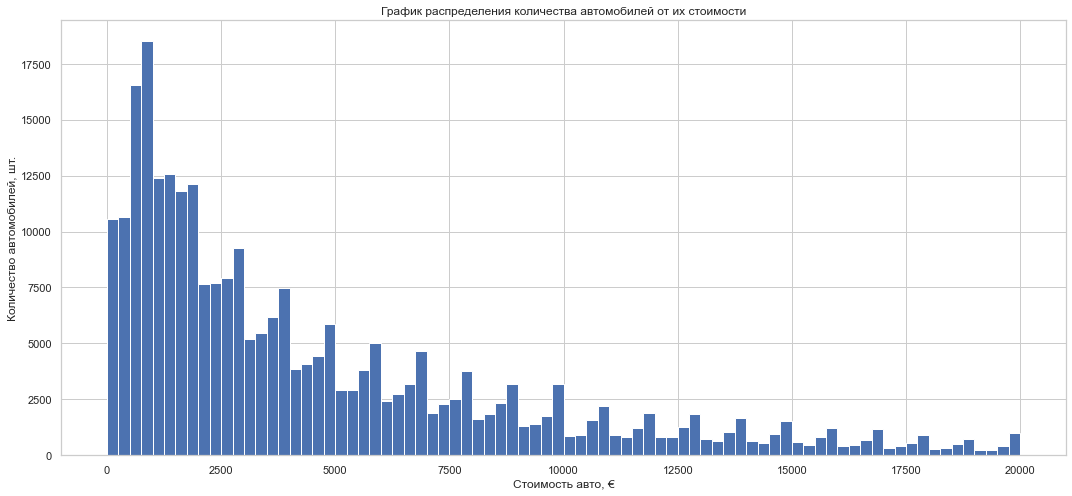

In [30]:
df['price'].plot(kind='hist', bins=80, grid=True, figsize=(18, 8), legend=False,
                 title='График распределения количества автомобилей от их стоимости')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Стоимость авто, €');

In [31]:
# аномально дешёвые автомобили
display(df[df['price'] < 200])
print(f'Из датасета удалено {len(df.query("price < 200"))} авто.')
df = df[df['price'] >= 200]

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,number_of_pictures,price,date_created,date_crawled,last_seen,postal_code,year_created,days
79,opel,astra,NaN,manual,75,petrol,150000,2016,3,yes,0,150,2016-03-17,2016-03-17 18:52:56,2016-04-05 03:45:22,78315,2016,21
89,mercedes_benz,e_klasse,sedan,manual,113,petrol,150000,1995,4,no,0,1,2016-03-28,2016-03-28 09:37:01,2016-04-06 12:15:54,40589,2016,10
152,opel,meriva,bus,manual,101,lpg,150000,2004,10,yes,0,0,2016-03-11,2016-03-11 18:55:53,2016-03-12 23:47:10,27432,2016,27
231,ford,mondeo,wagon,manual,115,NaN,150000,2001,0,undefined,0,0,2016-03-16,2016-03-16 22:06:24,2016-03-26 11:17:50,57627,2016,22
268,audi,80,sedan,manual,90,petrol,70000,1990,6,no,0,1,2016-03-11,2016-03-12 07:26:49,2016-03-26 23:15:49,55122,2016,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,ford,fiesta,small,manual,60,petrol,150000,2002,3,undefined,0,0,2016-03-20,2016-03-20 14:55:07,2016-04-06 18:45:23,33659,2016,18
354248,suzuki,swift,small,manual,53,petrol,150000,1999,3,undefined,0,0,2016-03-24,2016-03-24 13:48:05,2016-04-07 05:17:24,42329,2016,14
354273,opel,astra,small,manual,55,petrol,150000,1993,3,yes,0,150,2016-03-16,2016-03-16 15:47:56,2016-04-06 17:46:29,66424,2016,22
354277,seat,arosa,small,manual,37,petrol,150000,1999,7,yes,0,0,2016-03-10,2016-03-10 22:55:50,2016-03-12 23:46:32,22559,2016,28


Из датасета удалено 8953 авто.


### Почтовый индекс

Судя по формату индекса, его составу и основываясь на общем впечатлении об исходном датасете, имеется предположение, что исследуемая область находится на территории Германии.

In [32]:
df['postal_code'].unique()

array([66954, 90480, 91074, ..., 97259, 95691, 86751], dtype=int64)

### Фотографии в объявлениях

У всех объявлений отутствует достоверная информации о количестве фотографий автомобиля. У всех это значение ровняется нулю. Поскольку колонка `number_of_pictures` не содержить сколь угодно полезной информации, она будет удалена из датафрейма.

In [33]:
print('Типичная численность фотографий автомобиля, которая встречается в объявлениях:', df['number_of_pictures'].unique())

# удаление колонки 'number_of_pictures'
df.drop(columns=['number_of_pictures'], inplace=True)

Типичная численность фотографий автомобиля, которая встречается в объявлениях: [0]


## Заполнение пропусков

Все обработанные предыдущие параметры авто (в частности дубликаты и аномалии)  позволяют создать сводную таблицу из различных моделей авто и их комплектаций для заполнения пропусков в других авто. Принцип работы: если у случайного автомобиля пропущен лишь один параметр (к примеру: название модели), а остальные значения присутствуют, то по ним осуществляется поиск автомобиля в точно такими же параметрами. Если результат поиска выдаёт один автомобиль, этот ответ считается однознаный, и название модели этого автомобиля заполняет пропуск.

Автомобили, данные которых восстановить не получилось будут удалены.

In [34]:
# создание сводной таблицы различных моделей авто и их комплектаций
autos = df[['brand', 'model', 'vehicle_type', 'gearbox', 'power', 'fuel_type']]
autos = autos[~autos['brand'].isna()]
autos = autos[~autos['model'].isna()]
autos = autos[~autos['power'].isna()]
autos = autos[~autos['gearbox'].isna()]
autos = autos[~autos['fuel_type'].isna()]
autos = autos[~autos['vehicle_type'].isna()]

autos.drop_duplicates(inplace=True)
autos.sort_values(by=['brand', 'model'], inplace=True)

display(autos)

,brand,model,vehicle_type,gearbox,power,fuel_type
15254,alfa_romeo,145,sedan,manual,103,petrol
23713,alfa_romeo,145,small,manual,103,petrol
73386,alfa_romeo,145,coupe,manual,103,petrol
133817,alfa_romeo,145,sedan,manual,119,petrol
146336,alfa_romeo,145,sedan,manual,120,petrol
...,...,...,...,...,...,...
281887,volvo,xc_reihe,suv,auto,210,petrol
295575,volvo,xc_reihe,suv,auto,267,petrol
303282,volvo,xc_reihe,suv,auto,208,petrol
343491,volvo,xc_reihe,suv,auto,181,petrol


### Модели

In [35]:
%%time
nan_index = df[df['model'].isna()].index
counter = 0

for i in nan_index:
    
    # сохранение пар-ов авто
    brand = df.loc[i, 'brand']
    power = df.loc[i, 'power']
    gearbox = df.loc[i, 'gearbox']
    fuel_type = df.loc[i, 'fuel_type']
    vehicle_type = df.loc[i, 'vehicle_type']
    
    try:
        # поиск аналогичного автомобиля без пропусков в пар-ах
        source = autos[((autos['brand'] == brand) &
                        (autos['power'] == power) &
                        (autos['gearbox'] == gearbox) &
                        (autos['fuel_type'] == fuel_type) &
                        (autos['vehicle_type'] == vehicle_type))]
        
        # если существует лишь одна модель с такимиже пар-ми, то
        if len(source['model'].unique()) == 1:
            
            # пропуск заполняется этим уникальным названием модели
            df.loc[i, 'model'] = source['model'].unique()[0]
            counter = counter + 1
        
    except:
        print('Не удалось найти замену')

print('Количество восстановленных пропусков:', counter)
print('Количество удалённых объектов:       ', len(df[df['model'].isna()]))
df.dropna(subset=['model'], inplace=True)

Количество восстановленных пропусков: 808
Количество удалённых объектов:        7127
Wall time: 1min 29s


### Тип кузова

In [36]:
%%time
nan_index = df[df['vehicle_type'].isna()].index
counter = 0

for i in nan_index:
    brand = df.loc[i, 'brand']
    model = df.loc[i, 'model']
    power = df.loc[i, 'power']
    gearbox = df.loc[i, 'gearbox']
    fuel_type = df.loc[i, 'fuel_type']
    
    try:
        source = autos[((autos['brand'] == brand) &
                        (autos['model'] == model) &
                        (autos['power'] == power) &
                        (autos['gearbox'] == gearbox) &
                        (autos['fuel_type'] == fuel_type))]
        if len(source['vehicle_type'].unique()) == 1:
            df.loc[i, 'vehicle_type'] = source['vehicle_type'].unique()[0]
            counter = counter + 1
    except:
        print('Не удалось найти замену')

print('Количество восстановленных пропусков:', counter)
print('Количество удалённых объектов:       ', len(df[df['vehicle_type'].isna()]))
df.dropna(subset=['vehicle_type'], inplace=True)

Количество восстановленных пропусков: 287
Количество удалённых объектов:        5457
Wall time: 56.7 s


### Тип топлива

In [37]:
%%time
nan_index = df[df['fuel_type'].isna()].index
counter = 0

for i in nan_index:
    brand = df.loc[i, 'brand']
    model = df.loc[i, 'model']
    power = df.loc[i, 'power']
    gearbox = df.loc[i, 'gearbox']
    vehicle_type = df.loc[i, 'vehicle_type']
    
    try:
        source = autos[((autos['brand'] == brand) &
                        (autos['model'] == model) &
                        (autos['power'] == power) &
                        (autos['gearbox'] == gearbox) &
                        (autos['vehicle_type'] == vehicle_type))]
        if len(source['fuel_type'].unique()) == 1:
            df.loc[i, 'fuel_type'] = source['fuel_type'].unique()[0]
            counter = counter + 1
    except:
        print('Не удалось найти замену')

print('Количество восстановленных пропусков:', counter)
print('Количество удалённых объектов:       ', len(df[df['fuel_type'].isna()]))
df.dropna(subset=['fuel_type'], inplace=True)

Количество восстановленных пропусков: 3156
Количество удалённых объектов:        4889
Wall time: 1min 53s


### Трансмиссия

In [38]:
%%time
nan_index = df[df['gearbox'].isna()].index
counter = 0

for i in nan_index:
    brand = df.loc[i, 'brand']
    model = df.loc[i, 'model']
    power = df.loc[i, 'power']
    fuel_type = df.loc[i, 'fuel_type']
    vehicle_type = df.loc[i, 'vehicle_type']
    
    try:
        source = autos[((autos['brand'] == brand) &
                        (autos['model'] == model) &
                        (autos['power'] == power) &
                        (autos['fuel_type'] == fuel_type) &
                        (autos['vehicle_type'] == vehicle_type))]
        if len(source['gearbox'].unique()) == 1:
            df.loc[i, 'gearbox'] = source['gearbox'].unique()[0]
            counter = counter + 1
    except:
        print('Не удалось найти замену')

print('Количество восстановленных пропусков:', counter)
df['gearbox'].fillna('undefined', inplace=True)

Количество восстановленных пропусков: 500
Wall time: 35.2 s


In [39]:
# повторный поиск (контроль) новых дубликатов
dupl_autos = df[df[['brand', 'model', 'vehicle_type', 'gearbox', 'power', 'fuel_type', 'kilometer',
                    'registration_year', 'registration_month', 'repaired', 'price', 'date_created']].duplicated()].index

display(df.loc[dupl_autos])
df.drop(dupl_autos, inplace=True)
print(f'\n Из датасета удалено {len(dupl_autos)} авто.')

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,registration_month,repaired,price,date_created,date_crawled,last_seen,postal_code,year_created,days
60554,ford,kuga,suv,manual,150,petrol,20000,2015,6,no,18400,2016-03-23,2016-03-23 13:57:38,2016-03-31 00:17:19,50827,2016,15
70709,renault,laguna,wagon,manual,131,petrol,125000,2007,6,no,2100,2016-03-14,2016-03-14 12:53:43,2016-03-16 03:15:45,41472,2016,24
72661,opel,corsa,small,manual,45,petrol,150000,1996,1,yes,500,2016-03-30,2016-03-30 21:56:42,2016-04-05 12:20:44,27753,2016,8
73869,opel,omega,sedan,auto,144,petrol,150000,2000,12,no,3000,2016-03-06,2016-03-06 16:23:20,2016-03-11 07:16:27,64546,2016,32
76278,skoda,octavia,wagon,manual,150,petrol,150000,2008,1,no,10800,2016-03-27,2016-03-27 10:54:53,2016-04-07 06:44:56,82499,2016,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344354,volkswagen,transporter,bus,manual,174,petrol,150000,2006,6,no,18800,2016-04-03,2016-04-03 23:49:20,2016-04-06 04:17:31,24796,2016,4
347229,peugeot,4_reihe,wagon,manual,170,petrol,150000,2006,11,no,2500,2016-03-10,2016-03-10 09:53:50,2016-03-12 12:44:15,32130,2016,28
349163,toyota,corolla,small,manual,97,petrol,125000,2003,9,no,3690,2016-03-15,2016-03-15 16:49:28,2016-03-20 12:46:36,89415,2016,23
351816,daewoo,nubira,wagon,manual,124,petrol,150000,2002,7,no,850,2016-03-08,2016-03-16 18:47:15,2016-03-18 01:44:09,72393,2016,30



 Из датасета удалено 133 авто.


### Финальный шаг

Этап предобработки окончен и по этой причине, помимо колонки `number_of_pictures`, будут удалены колонки: `date_crawled` (дата скачивания анкеты объявления из базы) и `last_seen` (дата последней активности пользователя) поскольку их значения фактически не влияют на стоимость авто. А взамен колонки `date_created` (дата создания объявления) будут использованы те же данные, в упрощённом формате: `days` (кол-во дней с момента публикаций).

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,repaired,price,postal_code,days
0,jeep,grand,suv,auto,163,petrol,125000,2004,undefined,9800,90480,24
1,volkswagen,golf,small,manual,75,petrol,150000,2001,no,1500,91074,21
2,skoda,fabia,small,manual,69,petrol,90000,2008,no,3600,60437,7
3,bmw,3er,sedan,manual,102,petrol,150000,1995,yes,650,33775,3
4,peugeot,2_reihe,convertible,manual,109,petrol,150000,2004,no,2200,67112,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243012 entries, 0 to 243011
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   brand              243012 non-null  object
 1   model              243012 non-null  object
 2   vehicle_type       243012 non-null  object
 3   gearbox            243012 non-null  object
 4   power              243012 non-null  int64 
 5   fuel_type          243012 non-null  object
 6   kilometer          243012 non-null  int64 
 7   registration_year  243012 non-null  int64 
 8   repaired           243012 non-null  object
 9   price              243012 non-null  int64 
 10  postal_code        243012 non-null  int64 
 11  days               243012 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 22.2+ MB
None
Пропуски - отсутствуют.


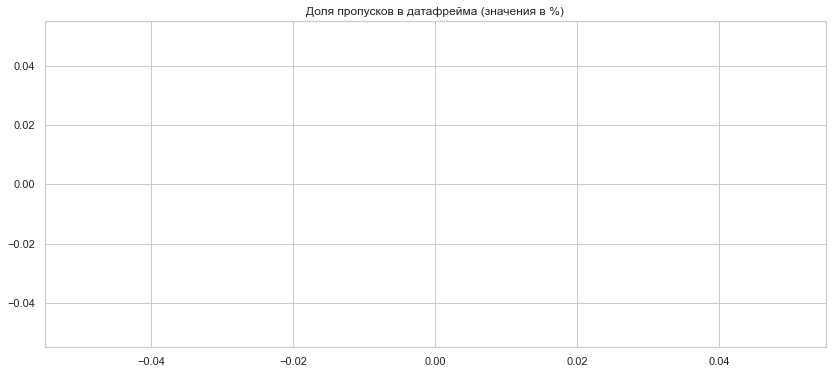

In [40]:
df.drop(columns=['date_crawled', 'last_seen', 'registration_month', 'date_created', 'year_created'], inplace=True)
df.reset_index(drop=True, inplace=True)

display(df.head())
print(df.info())
pass_value_barh(df)

**Итог:**
- **наименование столбцов** и содержание датафрейма приведено к единому стандарту: `змеиный_регистр`;
- явные **дубликаты**: выявлены и удалены повторно скаченные объявления;
- неявные дубликаты: типы топлива _gasoline_ и _petrol_ объеденены под последним названием, как наиболее популярным. Подобные дубликаты и ошибки в других колонках - отсутствуют;
- установленные **времянны́е рамки**: в датафрейме собраны объявления за последние 35 дней, и автомобили с 1990 - 2016 год регистрации;
- одинарные **пропуски** заполнены из параметров однотипных автомобилей. Была создана сводная таблица различных моделей авто их параметров, которая стала источником для дополнения пропусков;
- неявные пропуски: категория малоизвестных автомобилей `sonstige_autos` без точного имяни бренда/модели - удалены;
- **аномальные значения** (стоимость автомобиля 0€ и др.) - удалены;
- **индексация** обновлена.

По результату предобработки данных осталось около **243 000 объектов**, которые характеризуются следующими значениями (**12 колонок**) : `brand`,	`model`, `vehicle_type`, `gearbox`, `power`, `fuel_type,` `kilometer`, `registration_year`, `repaired`, `price`, `postal_code`, `days`.
___

## Обучение моделей

Перед началом нового раздела в проекте, напомню **ключевые технические термины**, которые будут далее использоваться в проекте:
- автомобиль — это объект,
- параметры автомобиля — признаки объекта,
- стоимость автомобиля — целевой признак, которые необходимо предсказать по значениям других признаков.

### Валидация данных

Деление исходного датасета на 3 выборки под разные задачи:
- **Тренировочная** (60%) — на её объектах модель будет обучена;
- **Валидационная** (20%) — на её объектах модель будет контролироваться и корректироваться её обучение;
- **Тестовая** (20%) — на её объектах будет произведён итоговый тест для оценки качества модели.

In [41]:
# выделение признаков
target = df['price']
features = df.drop(['price'], axis=1)

# выделение тренировочной выборки
X_train, X_other, Y_train, Y_other = train_test_split(features, target, train_size = 0.60, random_state = RANDOM_STATE)

# выделение валидационной и тестовой выборок
X_valid, X_test,  Y_valid, Y_test  = train_test_split(X_other,  Y_other, test_size = 0.50, random_state = RANDOM_STATE)

display(X_train.head())

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,repaired,postal_code,days
54638,audi,a4,wagon,manual,125,petrol,150000,1996,no,95515,20
108187,jeep,grand,suv,auto,231,petrol,150000,2006,no,49451,13
57546,volkswagen,golf,wagon,manual,105,petrol,50000,2013,no,42277,27
15898,chevrolet,matiz,small,manual,67,petrol,70000,2006,no,56244,4
175691,skoda,octavia,wagon,manual,125,petrol,90000,2011,undefined,40764,8


### Кодирование данных

Сформированные выборки необходимо подготовить к обучению, посколько в текущем формате модель будет работать не корректно.
- **Текстовые** (Категориальные) **данные** необходимо преобразовать (закодировать) в численные, с помощью  техники `Ordinal Encoding` поскольку она более предпочтителна для моделей Решающего дерева, используемые в градиентном бустинге;
- **Численные данные** необходимо привести к единому масштабу, с помощью  техники `Standard Scaler`. Благодаря этому все признаки будут иметь одинаковую значимость.

In [42]:
# кодирование признаков
category = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired']

# One Hot Encoding
X_train_ohe, X_valid_ohe, X_test_ohe = X_train, X_valid, X_test
for features in [X_train_ohe, X_valid_ohe, X_test_ohe]:
    features = pd.get_dummies(features, columns=category, drop_first=True)

# Ordinal Encoding
OE_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=(-1)) # UPD
OE_encoder.fit(X_train[category])
for features in [X_train, X_valid, X_test]:
    features[category] = OE_encoder.transform(features[category])
    
# масштабирование признаков
numeric = ['power', 'kilometer', 'registration_year', 'postal_code', 'days']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
for features in [X_train, X_valid, X_test]:
    features[numeric] = scaler.transform(features[numeric])

    
display(X_train.head())

,brand,model,vehicle_type,gearbox,power,fuel_type,kilometer,registration_year,repaired,postal_code,days
54638,1.0,29.0,7.0,1.0,0.153038,5.0,0.596558,-1.377183,0.0,1.712350,0.317646
108187,14.0,117.0,6.0,0.0,2.444987,5.0,0.596558,0.534793,0.0,-0.078735,-0.448321
57546,37.0,116.0,7.0,1.0,-0.279405,5.0,-2.152449,1.873176,0.0,-0.357679,1.083613
15898,3.0,148.0,5.0,1.0,-1.101047,5.0,-1.602648,0.534793,0.0,0.185394,-1.433135
175691,31.0,163.0,7.0,1.0,0.153038,5.0,-1.052847,1.490780,1.0,-0.416508,-0.995440


### Модель линейной регресии (LR)

Если можно так выразится, то это достаточно примитивная модель предсказывания, что является её и слабой и сильной стороной. Она проста в настройке, и выделяется высоким быстродействием. Особенно, если данные закодированы с помощью техники _One Hot Encoding_. Но может давать не такой точный результат, по сравнению с более сложными моделями.

In [43]:
%%time
rmse_min = 3000
for iteration in range(10, 101, 10): 
    model = LinearRegression(n_jobs=iteration)
    model.fit(X_train, Y_train)
    prediction_valid = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(Y_valid, prediction_valid))
    if rmse_min >= rmse:
        rmse_min = rmse 
        best_iter = iteration
        best_LR = model

print('Минимальная погрешность предсказаний: ± {:.0f}€, при количестве итераций: {}'.format(rmse_min, best_iter))

Минимальная погрешность предсказаний: ± 2531€, при количестве итераций: 100
Wall time: 1.07 s


In [44]:
%%time
rmse_min = 3000
for iteration in range(10, 101, 10): 
    model = LinearRegression(n_jobs=iteration)
    model.fit(X_train_ohe, Y_train)
    prediction_valid = model.predict(X_valid_ohe)
    rmse = np.sqrt(mean_squared_error(Y_valid, prediction_valid))
    if rmse_min >= rmse:
        rmse_min = rmse 
        best_iter = iteration
        best_prediction_valid = prediction_valid

print('Минимальная погрешность предсказаний: ± {:.0f}€, при количестве итераций: {}'.format(rmse_min, best_iter))

Минимальная погрешность предсказаний: ± 2531€, при количестве итераций: 100
Wall time: 899 ms


### Модель случайного леса (RF)

Ансамбль (набор) моделей решающих деревьев. Преимущество заключается в том, что вместе модели ошибаются в среднем не так сильно как по отдельности. Из ключевых параметров _Случайного леса_: количество деревьев и их глубина.

In [61]:
list_est_RF  = []
list_rmse_RF = []
rmse_min = 3000

for est in tqdm(range(10, 41, 10)):
    for depth in range(5, 16):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        model.fit(X_train, Y_train)
        prediction_valid = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(Y_valid, prediction_valid))
        if rmse_min >= rmse:
            rmse_min = rmse 
            best_dep = depth
            best_est = est
            best_RF = model
    list_est_RF.append(est)
    list_rmse_RF.append(rmse_min)

print('Минимальная погрешность: ± {:.0f}€, при кол-ве деревьев: {}, и их глубине: {}'.format(rmse_min, best_est, best_dep))

  0%|          | 0/4 [00:00<?, ?it/s]

Минимальная погрешность: ± 1496€, при кол-ве деревьев: 40, и их глубине: 15


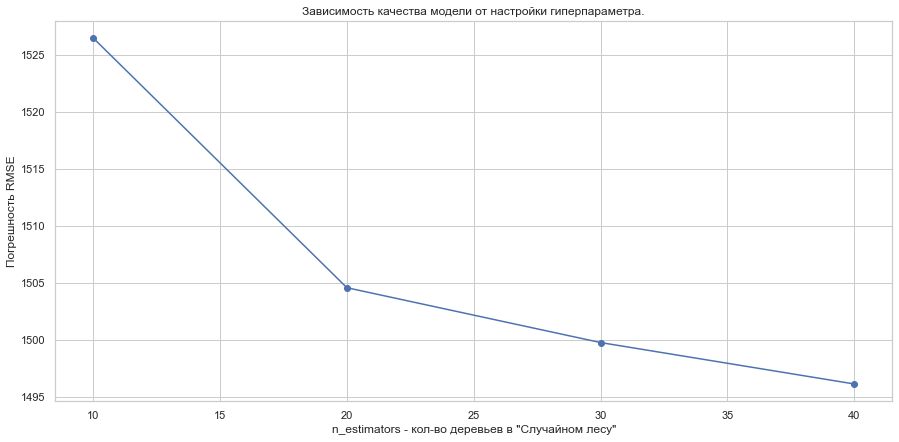

In [62]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'est': list_est_RF, 'rmse': list_rmse_RF})
rmse_score_data.plot(style='o-', x='est', y='rmse', grid=True, legend=False, figsize=(15,7),
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                     ylabel='Погрешность RMSE');

### Модель гриентного бустинга (LightGBM)

Последовательно построенный ансамблю моделей, каждая из которых учитывает ошибку предыдущей, и уменьшает её.

In [63]:
list_est_GBM  = []
list_rmse_GBM = []
rmse_min = 3000

for est in tqdm(range(10, 201, 10)):
    for depth in range(1, 6):
        model = lgb.LGBMRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        model.fit(X_train, Y_train)
        prediction_valid = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(Y_valid, prediction_valid))
        if rmse_min >= rmse:
            rmse_min = rmse 
            best_dep = depth
            best_est = est
            best_GBM = model
    list_est_GBM.append(est)
    list_rmse_GBM.append(rmse_min)

print('Погрешность модели: ± {:.0f}€, при кол-ве базовых моделей: {}, и их глубине: {}'.format(rmse_min, best_est, best_dep))

  0%|          | 0/20 [00:00<?, ?it/s]

Погрешность модели: ± 1495€, при кол-ве базовых моделей: 200, и их глубине: 5


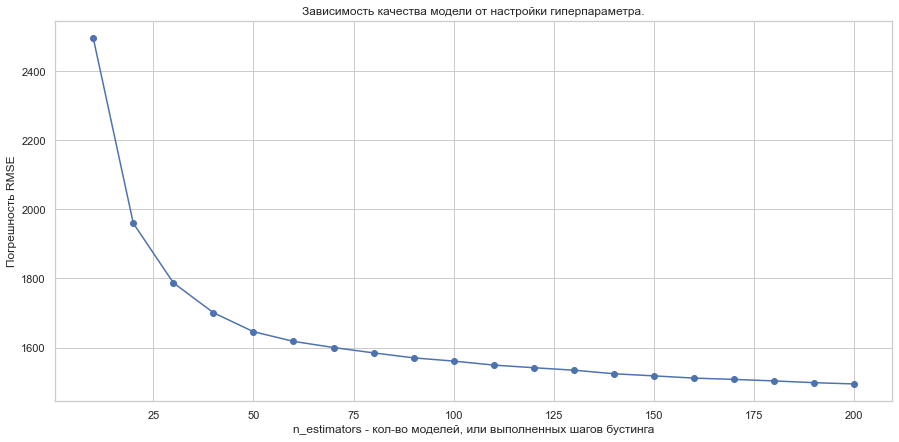

In [64]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'est': list_est_GBM, 'rmse': list_rmse_GBM})
rmse_score_data.plot(style='o-', x='est', y='rmse', grid=True, legend=False, figsize=(15,7),
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='n_estimators - кол-во моделей, или выполненных шагов бустинга',
                     ylabel='Погрешность RMSE')
plt.show()

## Анализ моделей

In [49]:
%%time

# ЛИНЕЙНАЯ РЕГРЕССИЯ, обученная на тренировочной выборке (60%)

model = best_LR
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 2532€
Wall time: 17 ms


In [50]:
%%time

# СЛУЧАЙНЫЙ ЛЕС, обученный на тренировочной выборке (60%)

model = best_RF
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 1515€
Wall time: 561 ms


In [51]:
%%time

# ГРАДИЕНТНЫЙ БУСТИНГ, обученный на тренировочной выборке (60%)

model = best_GBM
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 1511€
Wall time: 413 ms


In [52]:
# увеличение обучающей выборки за счёт объединения тренер. и валидацион. выборок (+ 20% объектов)
# (supp. - англ. supplemented, дополненный)

X_supp = pd.concat([X_train, X_valid], ignore_index=True)
Y_supp = pd.concat([Y_train, Y_valid], ignore_index=True)

In [53]:
%%time
# ЛИНЕЙНАЯ РЕГРЕССИЯ, обученная на тренировочной выборке (80%)

model = best_LR
model.fit(X_supp, Y_supp)

Wall time: 103 ms


LinearRegression(n_jobs=100)

In [54]:
%%time
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 2532€
Wall time: 12 ms


In [55]:
%%time
# СЛУЧАЙНЫЙ ЛЕС, обученный на дополненной выборке (80%)

model = best_RF
model.fit(X_supp, Y_supp)

Wall time: 39 s


RandomForestRegressor(max_depth=15, n_estimators=40, random_state=12345)

In [56]:
%%time
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 1487€
Wall time: 648 ms


In [57]:
%%time
# ГРАДИЕНТНЫЙ БУСТИНГ, обученный на дополненной выборке (80%)

model = best_GBM
model.fit(X_supp, Y_supp)

Wall time: 2.45 s


LGBMRegressor(max_depth=5, n_estimators=200, random_state=12345)

In [58]:
%%time
prediction_valid = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction_valid))
print('Погрешность модели: ± {:.0f}€'.format(rmse))

Погрешность модели: ± 1505€
Wall time: 416 ms


**ИТОГ:**
- **Линейная регрессия** - самая быстродейственная модель: общее время обучения и предсказаний не превышает **1 секунды*** (обучение: 45 мс., предсказания: 20 мс.). Но показала самую большую погрешность **± 2522€**. Эта модель подойдёт для других задач, к примеру для работы с бóльшим объёмом данных. При использовании кодирования _One Hot Encoding_ общее время сокращается примерно на 25%.
- **Случайный лес** - самая медлительная модель: **обучение: 22 с., предсказания 480 мс.*** Минимальнейшая погрешность предсказаний среди сравниваемых моделей: **± 1503€**.
- **Градиентный бустинг** - самая быстродейственная модель: **обучение 10 с., предсказание 560 мс.*** Погрешность предсказаний **± 1511€**, что соизмеримо с погрешностью предыдущей модели, но решающим значением является меньшее время. По этим причиная я рекомендую эту можель.

*время обучения и предсказания могут отличаться в зависимости от устройства (ПК/сервера) на которо выполняются эти операции.

_Примечание_: Увеличение обучающей выборки позволяет уменьшить погрешность предсказаний модели. Это очевидный вывод, но не очевидно как этого добиться, поскольку в исходных данных содержится значительное количество дефектов, устранение с которыми уменьшило объём данных, а так же потребовало больше времени, чем сам процесс обучения моделей и их тестирование.
___

## Чек-лист проверки

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей